In [1]:
from utils.dataloader import DataPartitions, DataGenerator
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
# sequences: array(
#   (x:Array, y:Dictionary)
# )
#
partitions = DataPartitions(
    past_frames=6,
    future_frames=2,
    root="../datasets/arda/04_21_full/",
    partial=0.8
)

In [3]:
dataset = DataGenerator(
    root="../datasets/arda/04_21_full/", 
    dataset_partitions=partitions.get_partitions(),
    past_frames=partitions.past_frames, 
    future_frames=partitions.future_frames,
    input_dim=(partitions.past_frames, 256, 256, 2),
    output_dim=(partitions.future_frames, 256, 256, 1), 
    batch_size=4,
    n_channels=1, 
    shuffle=True, # batch shuffling
    deep_shuffle = True, # datapoints shuffling
    buffer_size = 1e3,
    buffer_memory = 100
)

In [4]:
X = dataset.get_X()
Y = dataset.get_Y()

X[X > 10e5] = 0 
Y[Y > 10e5] = 0

100%|██████████| 152/152 [00:37<00:00,  4.10it/s]


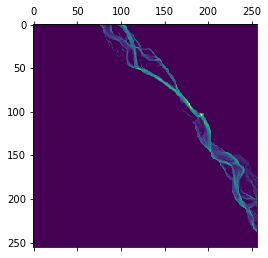

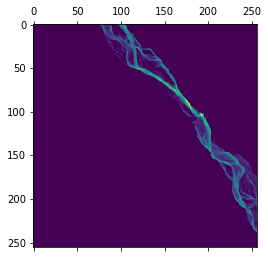

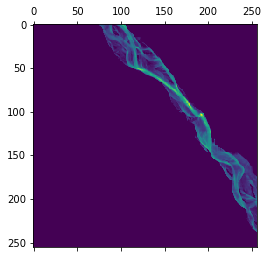

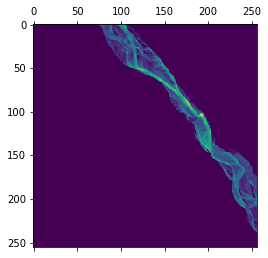

In [5]:
i = 0
j = 10
plt.matshow(X[j, i, 0, :, :, 0])
plt.matshow(X[j, i, 2, :, :, 0])
plt.matshow(X[j, i, 4, :, :, 0])
plt.matshow(Y[j, i, 0, :, :, 0])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [7]:
sc_img = StandardScaler() # image
sc_btm = StandardScaler() # image

for sample in X_train:
    for batch in sample:
        for frame in batch:
            sc_img.partial_fit(frame[:,:,0])
            #sc_btm.partial_fit(frame[:,:,2])

In [8]:
for s, sample in enumerate(X_train):
    for b, batch in enumerate(sample):
        for f, frame in enumerate(batch):
            X_train[s, b, f, :, :, 0] = sc_img.transform(frame[:,:,0])
            #X_train[s, b, f, :, :, 2] = sc_btm.transform(frame[:,:,2])
            
print("X_train ready")        

for s, sample in enumerate(X_test):
    for b, batch in enumerate(sample):
        for f, frame in enumerate(batch):
            X_test[s, b, f, :, :, 0] = sc_img.transform(frame[:,:,0])
            #X_test[s, b, f, :, :, 2] = sc_btm.transform(frame[:,:,2])
            
print("X_test transformed")
            
for s, sample in enumerate(y_train):
    for b, batch in enumerate(sample):
        for f, frame in enumerate(batch):
            y_train[s, b, f, :, :, 0] = sc_img.transform(frame[:,:,0])

print("y_train transformed")

for s, sample in enumerate(y_test):
    for b, batch in enumerate(sample):
        for f, frame in enumerate(batch):
            y_test[s, b, f, :, :, 0] = sc_img.transform(frame[:,:,0])
            
print("y_test transformed")

X_train ready
X_test transformed
y_train transformed
y_test transformed


In [9]:
print(X_test.shape)
print(y_test.shape)

(31, 4, 6, 256, 256, 2)
(31, 4, 2, 256, 256, 1)


### Model

In [10]:
import numpy as np

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

In [11]:
if th.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = th.device(dev) 

In [12]:
class ResNetBlock(nn.Module):
        
    def __init__(self, in_filters, filters, stride, kernel_size):
        super(ResNetBlock, self).__init__()
        
        self.activation = nn.ReLU()
        self.c1 = nn.Conv3d(in_filters, filters, kernel_size, stride, padding=1)
        self.c2 = nn.Conv3d(filters, filters, kernel_size, padding=1)
        self.c3 = nn.Conv3d(in_filters, filters, (1, 1, 1), stride)
        
        self.bn = nn.BatchNorm3d(num_features=filters)

    def forward(self, x,):
        
        residual = x
        
        y = self.c1(x)

        y = self.bn(y)
        y = self.activation(y)
        y = self.c2(y)
        y = self.bn(y)

        # reshape
        if residual.shape != y.shape:
            residual = self.c3(residual)
            residual = self.bn(residual)
            
        return self.activation(residual + y)


In [13]:
class Autoencoder(nn.Module):
    
    def __init__(self, channels, past_frames, future_frames):
        super(Autoencoder, self).__init__()

        kernel_size = 3

        self.layers = nn.ModuleList([
            nn.Conv3d(channels, 8, kernel_size, stride=1, padding=1),
            nn.AvgPool3d((2,2,2)),
            
            ResNetBlock(in_filters = 8, filters = 8, stride = 2, kernel_size=kernel_size),

            nn.Conv3d(8, 16, (1,1,1)),
            ResNetBlock(in_filters = 16, filters = 16, stride = 2, kernel_size=kernel_size),

            nn.Conv3d(16, 32, (1,1,1)),
            ResNetBlock(in_filters = 32, filters = 32, stride = 1, kernel_size=kernel_size),

            nn.Conv3d(32, 64, (1,1,1)),
            ResNetBlock(in_filters = 64, filters = 64, stride = 1, kernel_size=kernel_size),

            # ----------------------

            nn.ConvTranspose3d(64, 32, (1,2,2), stride=(1,2,2)),
            nn.BatchNorm3d(num_features=32),

            nn.ConvTranspose3d(32, 16, (1,2,2), stride=(1,2,2)),
            nn.BatchNorm3d(num_features=16),

            nn.ConvTranspose3d(16, 8, (2,2,2), stride=(2,2,2)),
            nn.BatchNorm3d(num_features=8),

            nn.ConvTranspose3d(8, 8, (1,1,1), stride=(1,1,1)),
            nn.BatchNorm3d(num_features=8),
            
            nn.ConvTranspose3d(8, 1, (1,1,1), stride=(1,1,1)),
            
        ])
    
    def forward(self, x, summary = False):
        
        if summary:
            print("==== Model Summary ====")
            print("{:<15s}{:>4s}".format("Block", "Output shape"))

        for i, l in enumerate(self.layers):
            x = l(x)
            
            if summary:
                print("{:<20s}{:>4s}".format(
                    str(l).split("(")[0],
                    str(x.shape).split("[")[1].split("]")[0]
                ))
        
        return x

In [14]:
net = Autoencoder(2, 4, 4).to(device)
net(th.Tensor(np.random.random((16, 2, 6, 256, 256))).to(device), True).shape

==== Model Summary ====
Block          Output shape
Conv3d              16, 8, 6, 256, 256
AvgPool3d           16, 8, 3, 128, 128
ResNetBlock         16, 8, 2, 64, 64
Conv3d              16, 16, 2, 64, 64
ResNetBlock         16, 16, 1, 32, 32
Conv3d              16, 32, 1, 32, 32
ResNetBlock         16, 32, 1, 32, 32
Conv3d              16, 64, 1, 32, 32
ResNetBlock         16, 64, 1, 32, 32
ConvTranspose3d     16, 32, 1, 64, 64
BatchNorm3d         16, 32, 1, 64, 64
ConvTranspose3d     16, 16, 1, 128, 128
BatchNorm3d         16, 16, 1, 128, 128
ConvTranspose3d     16, 8, 2, 256, 256
BatchNorm3d         16, 8, 2, 256, 256
ConvTranspose3d     16, 8, 2, 256, 256
BatchNorm3d         16, 8, 2, 256, 256
ConvTranspose3d     16, 1, 2, 256, 256


torch.Size([16, 1, 2, 256, 256])

In [15]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=10e-3)

In [16]:
X_train = th.Tensor(X_train).to(device)
y_train = th.Tensor(y_train).to(device)

In [17]:
X_train = X_train.permute(0, 1, 5, 2, 3, 4)
y_train = y_train.permute(0, 1, 5, 2, 3, 4)

In [18]:
X_test = th.Tensor(X_test).to(device)
y_test = th.Tensor(y_test).to(device)

In [19]:
X_test = X_test.permute(0, 1, 5, 2, 3, 4)
y_test = y_test.permute(0, 1, 5, 2, 3, 4)

In [20]:
def relative_error(y, y_true):
    return (th.norm(y - y_true, float('inf')) / th.norm(y_true, float('inf')))

In [21]:
losses = []
errors = []
test_errors = []

In [22]:
epochs = 20

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, batch in enumerate(X_train):

        optimizer.zero_grad()

        outputs = net(batch)
        
        loss = criterion(outputs, y_train[i])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        losses.append(loss.item())

        # print("batch {} - loss {}".format(i, loss.item()))

        if epoch % 2 == 0 and i == 0:
            # randomly pick a test batch and compute it
            i = np.random.randint(len(y_test), size=1)
            
            train_out = net(X_test[i][0])
            test_out = net(X_train[i][0])
            
            train_err = relative_error(train_out, y_train[i]).item()
            test_err = relative_error(test_out, y_test[i]).item()
        
            test_errors.append(test_err)
            errors.append(train_err)
            
            print('[%d, %5d] train_err: %.3f \t  test_err: %.3f' %
                  (epoch, i, train_err, test_err))
    
        #if epoch % 10 == 0:
        #    print('[%d, %5d] loss: %.3f' %
        #          (epoch + 1, i + 1, running_loss / 2000))
        #    running_loss = 0.0

print('Finished Training')

[0,     8] train_err: 1.260 	  test_err: 1.189
[0,    22] train_err: 1.015 	  test_err: 1.023
[0,     7] train_err: 1.027 	  test_err: 1.003
[0,    21] train_err: 1.007 	  test_err: 1.032
[0,     2] train_err: 1.007 	  test_err: 1.031
[0,    27] train_err: 2.240 	  test_err: 1.668
[0,    13] train_err: 1.007 	  test_err: 1.033
[0,     8] train_err: 0.988 	  test_err: 1.015
[0,     8] train_err: 0.996 	  test_err: 1.014
[2,     6] train_err: 1.014 	  test_err: 1.011
[2,     5] train_err: 2.514 	  test_err: 1.002
[2,    25] train_err: 1.692 	  test_err: 1.009
[2,    15] train_err: 1.019 	  test_err: 1.003
[2,    15] train_err: 1.045 	  test_err: 1.000
[2,    20] train_err: 1.425 	  test_err: 1.011
[2,    10] train_err: 1.338 	  test_err: 0.981
[2,    25] train_err: 1.759 	  test_err: 1.008
[2,    12] train_err: 1.510 	  test_err: 0.998
[4,    23] train_err: 1.037 	  test_err: 1.000
[4,    26] train_err: 1.018 	  test_err: 1.004
[4,    27] train_err: 1.233 	  test_err: 1.278
[4,     4] tr

In [23]:
'''
i = 16
j = 20
plt.matshow(X[i, 0, 0, :, :, 0])
plt.matshow(X[j, 0, 1, :, :, 0])
'''

'\ni = 16\nj = 20\nplt.matshow(X[i, 0, 0, :, :, 0])\nplt.matshow(X[j, 0, 1, :, :, 0])\n'

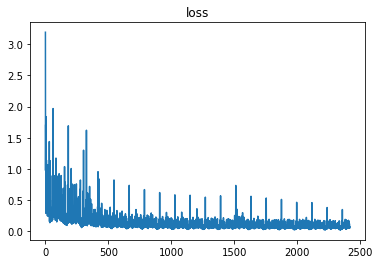

In [24]:
plt.title("loss")
plt.plot(range(len(losses)), losses)
pass

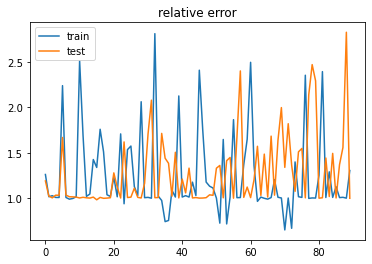

In [25]:
plt.title("relative error")
plt.plot(range(len(errors)), errors, label="train")
plt.plot(range(len(test_errors)), test_errors, label="test")
plt.legend()
pass


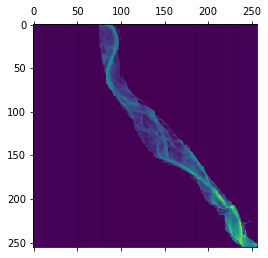

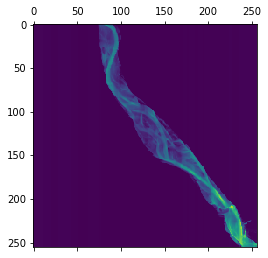

In [26]:
i = np.random.randint(len(X_test))
outputs = net(X_test[i])
for frame in y_test[i][0][0]:
    plt.matshow(frame.cpu().detach().numpy())

torch.Size([4, 1, 2, 256, 256])


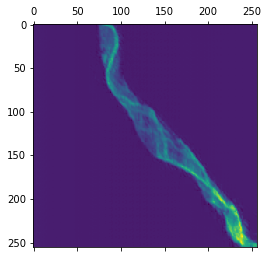

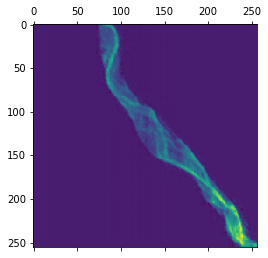

In [27]:
print(outputs.shape)
for frame in outputs[0][0]:
    plt.matshow(frame.cpu().detach().numpy())


[0.004241813, 0.005888382]

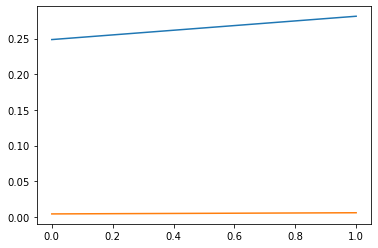

In [34]:
frames = len(outputs[0][0])
plt.plot(range(frames), [np.average(x.cpu().detach().numpy()) for x in y_test[i][0][0]])
plt.plot(range(frames), [np.average(x.cpu().detach().numpy()) for x in outputs[0][0]])
[np.average(x.cpu().detach().numpy()) for x in outputs[0][0]]

In [29]:
print("{:<20s}{:<20s}{:<20s}{:<20s}{:<20s}".format("", "min", "max", "mean", "std"))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("prediction", th.min(outputs), th.max(outputs), th.mean(outputs), th.std(outputs)))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("true", th.min(y_test[0]), th.max(y_test[0]), th.mean(y_test[0]), th.std(y_test[0])))

                    min                 max                 mean                std                 
prediction          -1.761513           14.921329           0.022787            1.603495            
true                -0.318235           13.417292           0.169060            1.308609            
